# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [2]:
!pip show tensorflow

In [3]:
!pip install tensorflow

  Using cached tensorflow-2.18.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
Using cached tensorflow-2.18.0-cp312-cp312-macosx_12_0_arm64.whl (239.6 MB)
Using cached keras-3.7.0-py3-none-any.whl (1.2 MB)


In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Let's get the data!

In [5]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the corpus
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [7]:
# Calculate the vocabulary size
total_words = len(tokenizer.word_index) + 1

# Print the result
print(f"Total vocabulary size: {total_words}")

Total vocabulary size: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [8]:
# Create an empty list for storing input sequences
input_sequences = []

# Generate n-gram sequences for each sentence in the corpus
for line in corpus:
    # Convert the text into a sequence of integers
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    # Generate n-gram sequences
    for i in range(1, len(token_list) + 1):
        n_gram_sequence = token_list[:i]
        input_sequences.append(n_gram_sequence)

Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Step 1: Calculate the length of the longest sequence
max_sequence_len = max(len(seq) for seq in input_sequences)
print(f"Maximum sequence length: {max_sequence_len}")

# Step 2: Pad the sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Step 3: Convert to a numpy array
input_sequences = np.array(input_sequences)
print(f"Padded input sequences shape: {input_sequences.shape}")

Maximum sequence length: 11
Padded input sequences shape: (17805, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [10]:
# Split the input_sequences into predictors and labels
predictors = input_sequences[:, :-1]  # All elements except the last one
labels = input_sequences[:, -1]       # The last element of each sequence

# Print the shapes to verify
print(f"Shape of predictors: {predictors.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of predictors: (17805, 10)
Shape of labels: (17805,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [11]:
# One-hot encode the labels
labels = ku.to_categorical(labels, num_classes=total_words)

# Print the result to verify
print(f"Shape of one-hot encoded labels: {labels.shape}")


Shape of one-hot encoded labels: (17805, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [12]:
model = Sequential([
    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(total_words, activation='softmax')
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [14]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [15]:
# Train the model for 50 epochs
history = model.fit(predictors, labels, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.0263 - loss: 8.0251 - val_accuracy: 0.0236 - val_loss: 6.7886
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.0265 - loss: 6.4772 - val_accuracy: 0.0236 - val_loss: 6.8257
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.0276 - loss: 6.3859 - val_accuracy: 0.0286 - val_loss: 6.8691
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.0335 - loss: 6.2530 - val_accuracy: 0.0286 - val_loss: 6.9574
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.0395 - loss: 6.1604 - val_accuracy: 0.0315 - val_loss: 7.0028
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.0414 - loss: 6.0789 - val_accuracy: 0.0340 - val_loss: 7.0728
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.0439 - loss: 5.9978 - val_accuracy: 0.0382 - val_loss: 7.1590
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.0478 - loss: 5.9622 - val_accu

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

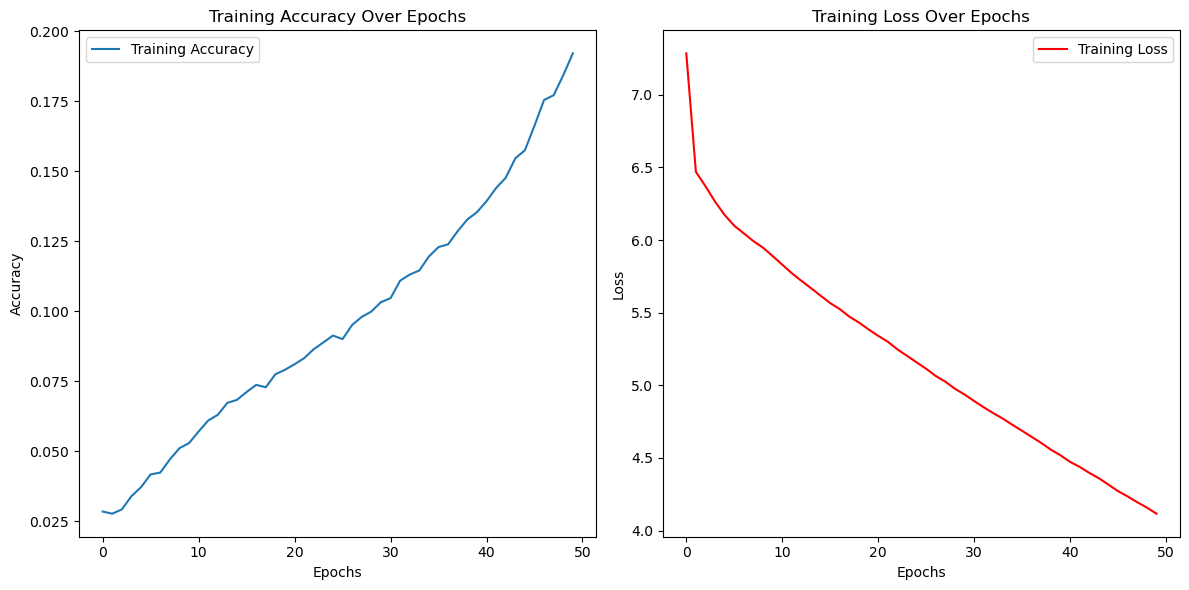

In [16]:
import matplotlib.pyplot as plt

# Extract accuracy and loss data from the training history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='r')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [18]:
# Seed text to start the generation process
seed_text = "FROM fairest creatures we desire increase, That thereby beauty's rose might never die," 

# Number of words you want to generate
next_words = 50  

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [19]:
# Convert the seed text into a sequence of integers using the tokenizer
for _ in range(next_words):
    # Tokenize the seed text (convert words to integer sequences)
    tokenized_text = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Pad the tokenized text to ensure it has the correct input length
    tokenized_text = pad_sequences([tokenized_text], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word using the trained model
    predicted_probs = model.predict(tokenized_text, verbose=0)
    
    # Get the index of the word with the highest probability
    predicted_word_index = np.argmax(predicted_probs)
    
    # Convert the predicted index back to the word
    predicted_word = tokenizer.index_word[predicted_word_index]
    
    # Append the predicted word to the seed text
    seed_text += ' ' + predicted_word

# Display the generated text
print(seed_text)

FROM fairest creatures we desire increase, That thereby beauty's rose might never die, heart now love beauty beauty now thee me beauty for me now lie look it lie unrespected days days days you beauty beauty now me beauty beauty beauty beauty beauty now thee now beauty lie hate eyes lie look it days days beauty now beauty lie look now you lie


Experiment with at least 3 different seed_text strings and see what happens!

In [25]:
# Seed text 2
seed_text = "Thyself thy foe, to thy sweet self too cruel." 

for _ in range(next_words):
    tokenized_text = tokenizer.texts_to_sequences([seed_text])[0]
    tokenized_text = pad_sequences([tokenized_text], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = model.predict(tokenized_text, verbose=0)
    predicted_word_index = np.argmax(predicted_probs)
    predicted_word = tokenizer.index_word[predicted_word_index]
    seed_text += ' ' + predicted_word

# Display the generated text
print(seed_text)

Thyself thy foe, to thy sweet self too cruel. rhyme doom to cross woe poet's living pen view lie look it prove me beauty beauty time in time remains lie look it lie look it now me you know it now thee are thee it beauty now lie look it now lie unrespected days days time beauty all me


In [23]:
# Seed text 3
seed_text = "Where all the treasure of thy lusty days," 

for _ in range(next_words):
    tokenized_text = tokenizer.texts_to_sequences([seed_text])[0]
    tokenized_text = pad_sequences([tokenized_text], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = model.predict(tokenized_text, verbose=0)
    predicted_word_index = np.argmax(predicted_probs)
    predicted_word = tokenizer.index_word[predicted_word_index]
    seed_text += ' ' + predicted_word

# Display the generated text
print(seed_text)

Where all the treasure of thy lusty days, light days days now beauty lie time beauty beauty beauty beauty beauty beauty beauty beauty beauty lie hate heart it lie look it days now now alone lie look it do thee me beauty beauty now lie weed of night it lie look it time all beauty now thee now
